In [1]:
import numpy as np 
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from random import shuffle
from keras.utils  import to_categorical


import pickle
import tensorflow as tf


In [2]:
!pwd
tf
print("Num GPUs Available: ", tf.config.experimental.list_physical_devices())
#???

/media/jp/3aa509e1-f76e-48e5-bcb0-bc671881dca6/home/jp/orange-classifier
Num GPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]


In [5]:
##Estudando os dados....
#OpenCV-Python is a library of Python bindings designed to solve computer vision problems. 
#cv2.cvtColor() method is used to convert an image from one color space to another. There are more than 150
#color-space conversion methods available in OpenCV. We will use some of color space conversion codes below.
def load_rand():
    X=[]
    dir_path='./archive/dataset/dataset/train' #Diretorio dos dados de treinamento
    for sub_dir in tqdm(os.listdir(dir_path)):
        print(sub_dir)
        path_main=os.path.join(dir_path,sub_dir) #rottenoranges vs freshoranges
        print(path_main)
        i=0
        for img_name in os.listdir(path_main): #Loop in each directory ['fresh', 'rotten']
            print(img_name)
            if i>=12: #Read 18 images each directory (36 in total)
                break
            img=cv2.imread(os.path.join(path_main,img_name)) #read image
            img=cv2.resize(img,(100,100)) #resize image 100x100 pixels
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #convert image
            X.append(img)
            i+=1
    return X

In [6]:
X=load_rand()

  0%|          | 0/3 [00:00<?, ?it/s]

rottenoranges
./archive/dataset/dataset/train/rottenoranges
rotated_by_45_Screen Shot 2018-06-12 at 11.47.08 PM.png
rotated_by_60_Screen Shot 2018-06-12 at 11.36.14 PM.png
rotated_by_15_Screen Shot 2018-06-12 at 11.41.35 PM.png
rotated_by_60_Screen Shot 2018-06-12 at 11.40.51 PM.png
vertical_flip_Screen Shot 2018-06-12 at 11.26.44 PM.png
rotated_by_60_Screen Shot 2018-06-12 at 11.26.07 PM.png
vertical_flip_Screen Shot 2018-06-12 at 11.29.36 PM.png
Screen Shot 2018-06-12 at 11.29.14 PM.png
saltandpepper_Screen Shot 2018-06-12 at 11.41.35 PM.png
rotated_by_45_Screen Shot 2018-06-12 at 11.24.37 PM.png
Screen Shot 2018-06-12 at 11.45.17 PM.png
rotated_by_15_Screen Shot 2018-06-12 at 11.25.11 PM.png
vertical_flip_Screen Shot 2018-06-12 at 11.40.42 PM.png
lessorange
./archive/dataset/dataset/train/lessorange
aug_2014.jpg
aug_3308.jpg
aug_3246.jpg
aug_3067.jpg
aug_3338.jpg
aug_3247.jpg
aug_127.jpg
aug_2315.jpg
aug_2325.jpg
aug_2871.jpg
aug_2555.jpg
aug_2254.jpg


100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

aug_3332.jpg
freshoranges
./archive/dataset/dataset/train/freshoranges
rotated_by_75_Screen Shot 2018-06-12 at 11.51.08 PM.png
Screen Shot 2018-06-12 at 11.53.22 PM.png
rotated_by_75_Screen Shot 2018-06-13 at 12.07.05 AM.png
saltandpepper_Screen Shot 2018-06-13 at 12.07.46 AM.png
vertical_flip_Screen Shot 2018-06-13 at 12.01.10 AM.png
rotated_by_15_Screen Shot 2018-06-13 at 12.02.41 AM.png
rotated_by_45_Screen Shot 2018-06-13 at 12.11.10 AM.png
rotated_by_75_Screen Shot 2018-06-13 at 12.08.58 AM.png
rotated_by_30_Screen Shot 2018-06-13 at 12.14.32 AM.png
rotated_by_15_Screen Shot 2018-06-13 at 12.18.34 AM.png
rotated_by_15_Screen Shot 2018-06-13 at 12.03.55 AM.png
vertical_flip_Screen Shot 2018-06-13 at 12.15.21 AM.png
rotated_by_45_Screen Shot 2018-06-13 at 12.20.06 AM.png


In [7]:
X=np.array(X)
X.shape #36 linhas de imagens de 100x100 pixels com profundidade 3 (RGB)
#onde R é Vermelho, G é Verde e B é Azul

(36, 100, 100, 3)

In [8]:
def show_subpot(X,title=False,Y=None):
    if X.shape[0]==36:
        f, ax= plt.subplots(6,6, figsize=(40,60))
        list_fruits=['rottenoranges', 'freshoranges'] #categorias.
        
        for i,img in enumerate(X):
            ax[i//6][i%6].imshow(img, aspect='auto')
            if title==False:
                ax[i//6][i%6].set_title(list_fruits[i//18])
        plt.show()
    else:
        print('Cannot plot')

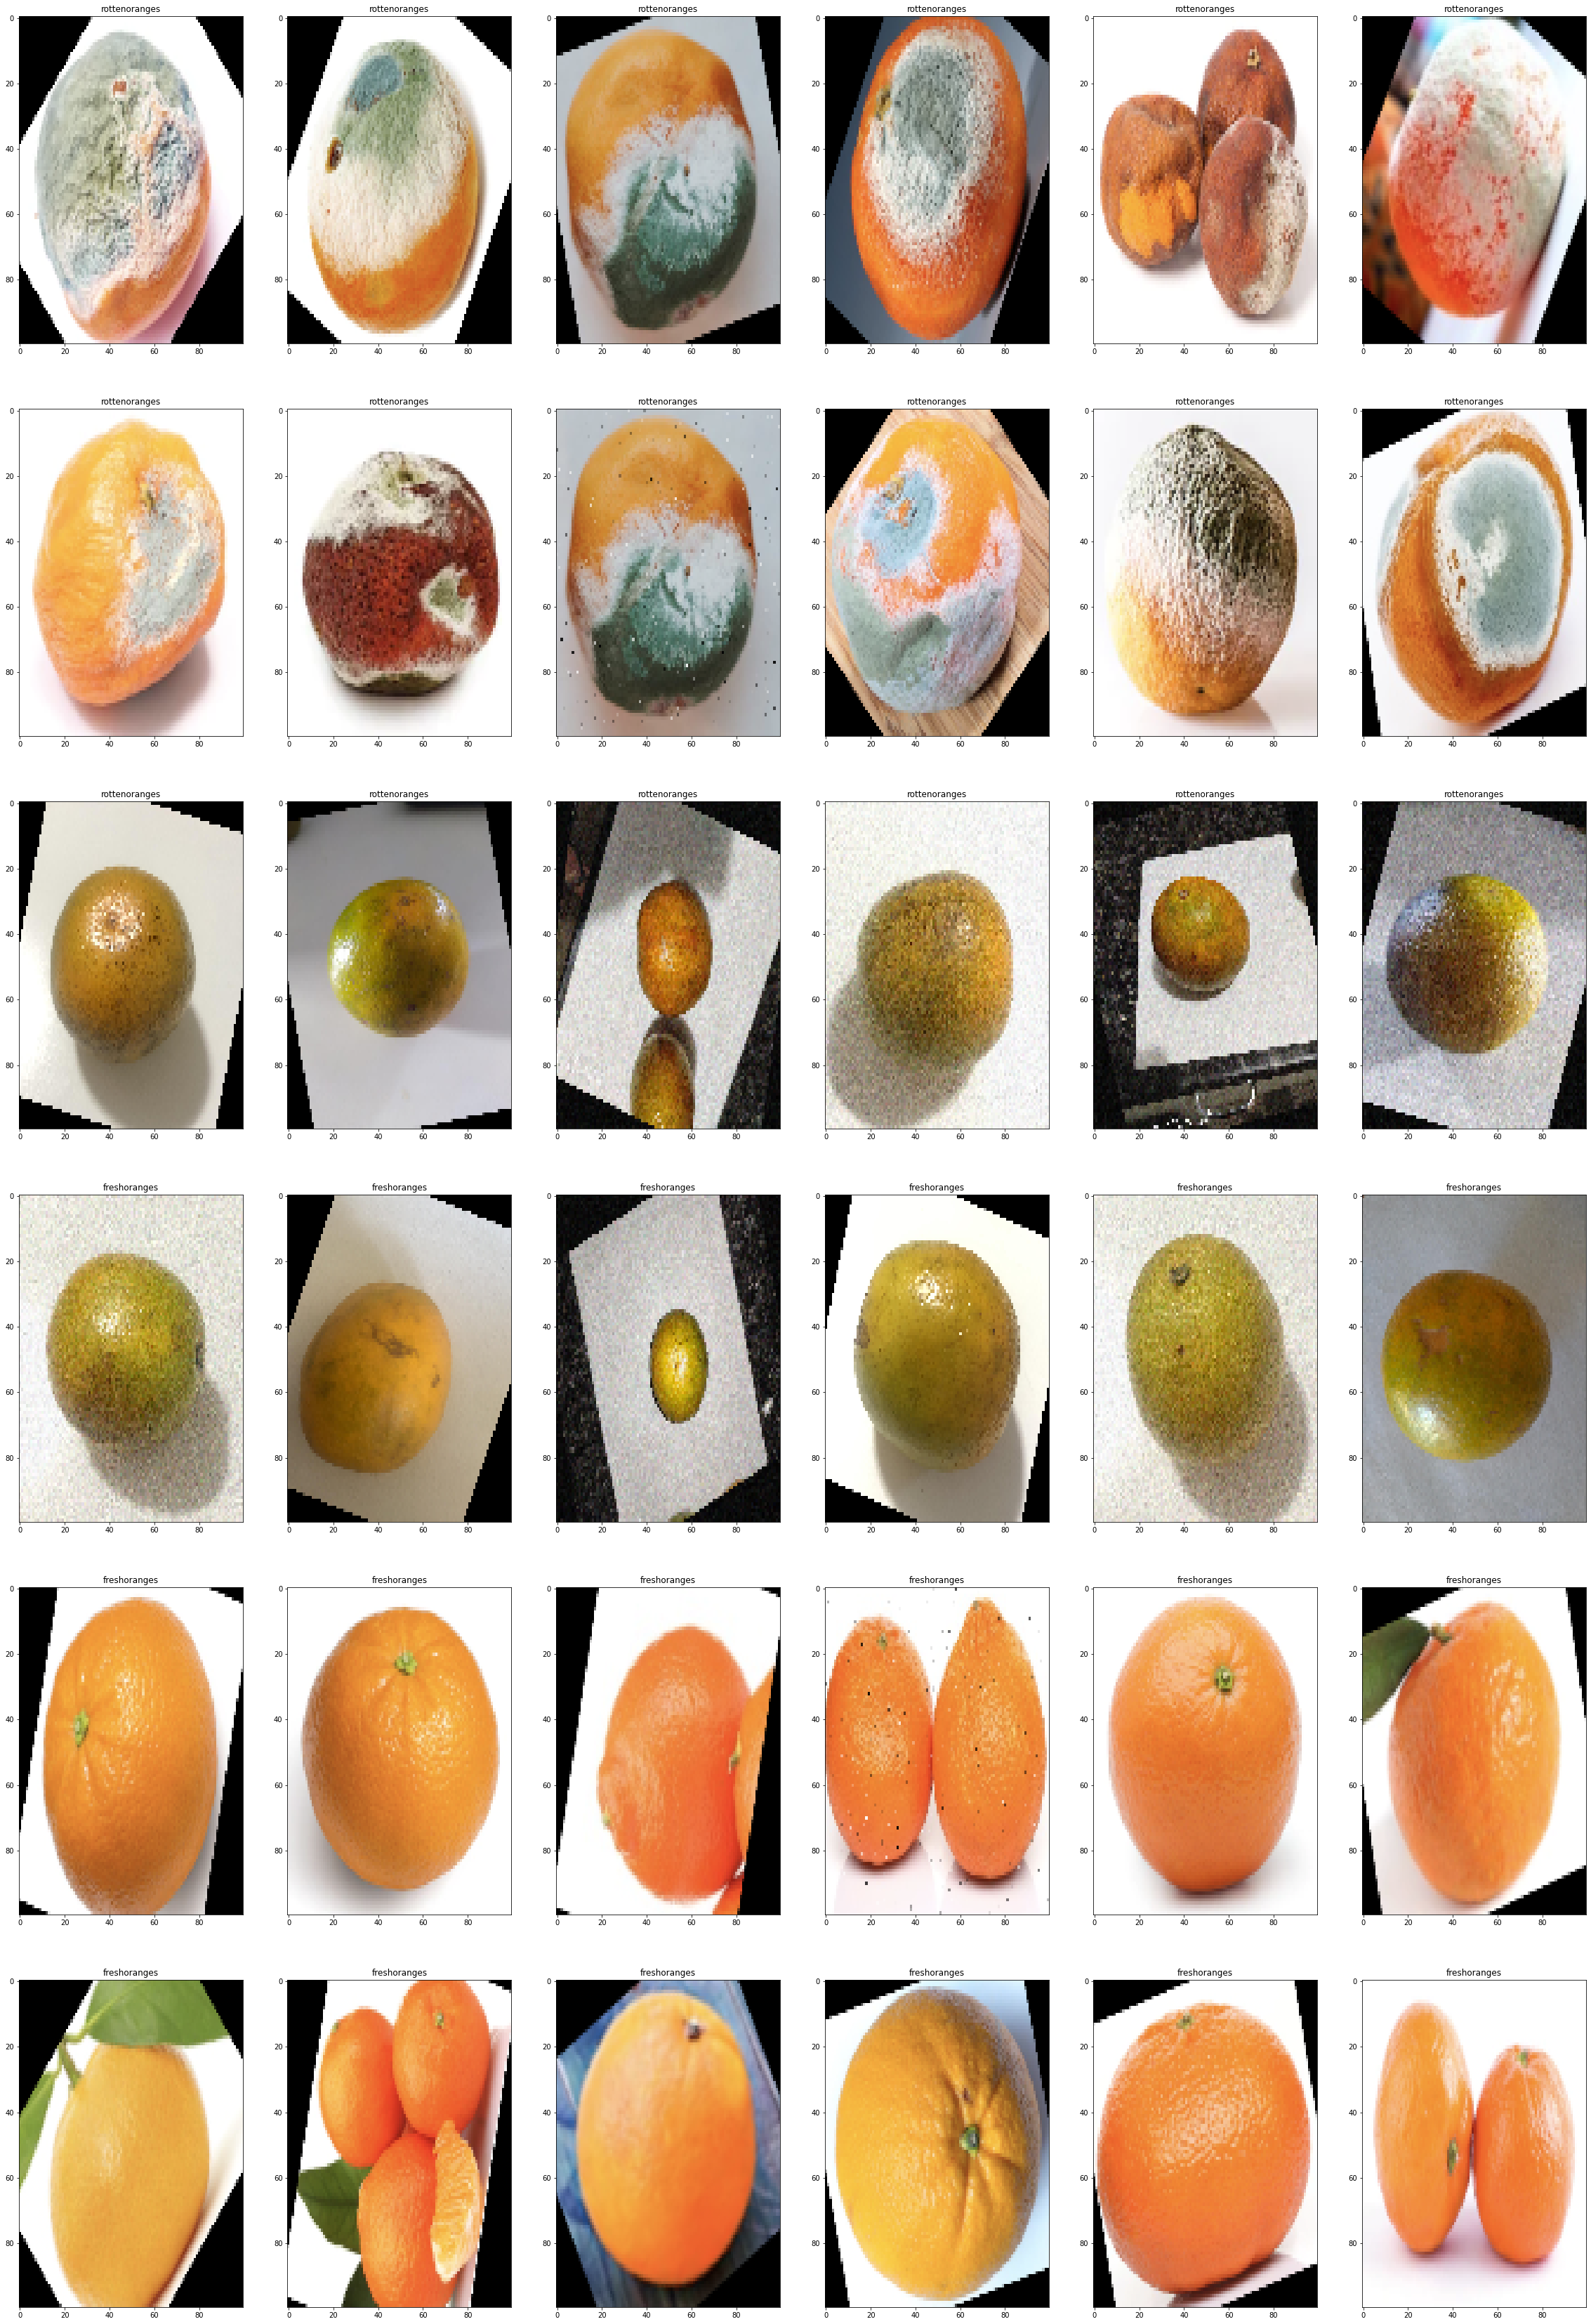

In [9]:
show_subpot(X)
#img = plt.imshow (X [1], aspect='auto')


In [10]:
del X

In [10]:
#Carrega as imagens e coloca labels para elas
def load_rottenvsfresh():
    
    quality=['fresh', 'rotten', 'less']
    
    X,Y=[],[]
    z=[]
    #BOAS SEM MANCHAS -> LABEL 0
    #RUINS -> LABEL 1
    #BOA COM MANCHAS -> LABEL 2
    for cata in tqdm(os.listdir('./archive/dataset/dataset/train')):
        if quality[0] in cata:
            path_main=os.path.join('./archive/dataset/dataset/train',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,0]) #fresh
        elif quality[1] in cata:
            path_main=os.path.join('./archive/dataset/dataset/train',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,1]) #rotten
        else:
            path_main=os.path.join('./archive/dataset/dataset/train',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,2]) #less
    print('Shuffling your data.....')
    
    shuffle(z)
    for images, labels in tqdm(z):
        print(labels)
        X.append(images);Y.append(labels)
    return X,Y

In [11]:
X,Y=load_rottenvsfresh()


 28%|██▊       | 1515/5344 [00:00<00:00, 14748.45it/s]

Shuffling your data.....
0
2
2
2
0
1
0
2
2
2
1
1
2
2
0
0
1
1
1
2
2
0
1
2
0
2
2
0
2
1
2
0
2
2
1
0
2
0
2
2
0
1
1
0
0
0
0
2
2
2
2
2
2
2
1
2
1
2
0
2
2
1
0
0
0
0
2
2
1
1
1
2
1
2
0
1
1
0
1
0
1
1
0
1
0
1
1
1
2
1
0
2
2
0
0
2
1
1
2
1
1
1
2
1
1
2
2
2
2
1
0
1
0
2
2
0
2
2
2
0
0
2
2
0
2
2
2
0
2
1
1
1
0
2
0
2
1
2
2
2
1
1
2
0
2
0
2
1
2
0
0
2
2
2
2
1
1
2
2
2
1
0
2
1
0
2
1
2
2
1
0
2
2
2
1
0
0
0
1
2
1
0
2
1
2
1
2
1
2
1
2
2
0
2
2
1
0
1
1
0
2
2
2
2
1
0
2
1
2
2
2
2
2
2
1
1
0
1
2
2
2
2
0
1
1
1
1
2
2
0
1
2
1
2
1
0
2
2
2
1
2
0
0
1
0
0
2
1
1
0
0
2
2
1
2
0
0
2
2
2
0
2
1
2
0
1
1
0
2
2
2
2
0
1
1
1
0
0
2
2
2
2
0
0
2
2
1
2
2
1
1
1
2
2
2
1
1
0
0
1
1
0
1
0
2
2
1
2
2
0
1
2
1
2
2
1
1
1
2
2
1
0
1
2
0
2
2
1
2
2
2
2
2
0
0
0
2
0
0
1
2
2
2
1
1
2
2
2
2
2
2
1
2
1
2
2
0
2
0
0
2
2
0
2
1
1
1
0
1
2
1
1
2
2
0
1
1
1
0
2
2
0
0
0
0
2
2
2
1
1
1
0
2
0
2
2
1
1
2
2
0
0
2
0
1
1
2
2
2
1
0
1
1
0
1
2
2
1
1
1
0
0
1
1
0
2
1
1
0
2
1
2
2
2
2
1
0
0
1
1
1
0
1
2
0
2
0
0
2
0
0
1
0
1
1
1
2
2
2
2
2
2
2
0
2
2
1
0
0
0
0
0
2
1
2
1
2
2
0
0
0
2
2
1
2
1
1
0

100%|██████████| 5344/5344 [00:00<00:00, 15938.45it/s]


0
0
0
1
0
2
2
2
2
1
0
0
2
0
1
1
1
1
1
1
0
2
1
1
1
1
2
0
2
1
0
1
2
1
2
2
1
2
1
2
0
2
2
0
1
1
2
2
2
1
1
2
1
1
0
0
0
2
0
0
0
0
1
2
0
2
2
2
0
1
0
2
1
0
0
1
2
1
1
0
2
1
0
1
2
2
1
1
0
2
2
0
0
0
1
1
0
2
2
2
0
2
1
0
2
2
2
2
2
2
2
0
2
1
1
2
1
1
1
1
2
2
0
0
1
2
2
0
2
2
2
2
1
1
1
2
1
1
2
0
2
2
2
2
2
1
1
2
0
1
1
1
0
2
1
2
2
0
0
1
1
0
0
0
1
0
2
2
1
1
1
2
1
1
2
1
1
1
1
0
2
2
1
2
1
2
1
1
0
2
2
1
2
2
2
1
1
0
2
2
2
2
1
1
1
0
1
1
2
1
1
1
2
0
0
2
2
2
0
1
1
1
2
0
2
1
1
2
2
0
2
1
0
0
2
0
2
2
2
1
2
0
0
2
2
1
2
2
1
0
2
2
0
0
0
0
2
2
0
2
1
1
2
0
2
1
1
0
1
0
1
0
1
2
2
0
2
2
1
0
0
2
2
1
2
1
2
1
0
2
1
2
1
2
0
1
1
0
2
0
1
0
2
2
0
2
2
2
1
2
0
2
2
2
2
2
2
1
2
1
2
1
2
2
2
1
2
2
2
2
0
0
1
0
2
2
2
2
1
0
0
0
2
0
1
1
0
0
2
1
1
2
2
1
2
0
2
1
0
1
0
0
0
2
1
2
2
0
0
0
2
2
2
1
2
2
0
2
2
2
0
2
2
1
2
1
2
0
1
2
0
2
1
2
2
0
1
0
2
0
0
2
0
2
1
2
2
0
0
2
1
2
0
1
2
0
2
0
0
0
0
1
0
2
1
1
0
0
2
1
1
2
0
1
2
2
2
2
2
2
2
1
1
2
0
0
0
1
2
2
0
0
0
1
2
1
0
2
1
0
0
1
1
0
1
2
0
2
2
2
1
1
0
1
0
2
1
1
2
0
0
1
0
2
1
2
1
2
2
1
0
0
0
1
0
1
1
0
1
2

In [12]:
Y=np.array(Y)
X=np.array(X)

In [13]:
y_ser=pd.Series(Y)
y_ser.value_counts()

2    2283
1    1595
0    1466
dtype: int64

In [14]:
def load_rottenvsfresh_valset():
    quality=['fresh', 'rotten', 'less']
    X,Y=[],[]
    z=[]
    for cata in tqdm(os.listdir('./archive/dataset/dataset/test')):
        if quality[1] in cata:
            path_main=os.path.join('./archive/dataset/dataset/test',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,1])
        elif quality[1] in cata:
            path_main=os.path.join('./archive/dataset/dataset/test',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,1]) #rotten
        else:
            path_main=os.path.join('./archive/dataset/dataset/test',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,2]) #less

    print('Shuffling your data.....')
    shuffle(z)
    for images, labels in tqdm(z):
        X.append(images);Y.append(labels)        
    return X,Y      

In [15]:
X_val,Y_val=load_rottenvsfresh_valset()


100%|██████████| 1975/1975 [00:00<00:00, 2336083.02it/s]

Shuffling your data.....


In [16]:
Y_val=np.array(Y_val)
X_val=np.array(X_val)

y_ser=pd.Series(Y_val)
y_ser.value_counts()



2    1569
1     406
dtype: int64

In [17]:
import keras 
from keras.layers import Dense,Dropout, Conv2D,MaxPooling2D , Activation, Flatten, BatchNormalization, SeparableConv2D
from keras.models import Sequential

In [18]:
#Para construir o modelo, precisamos criar a arquitetura usando Sequential().
model = Sequential()

#Em seguida, adicionamos a primeira camada, uma camada de convolução para extrair 
#recursos da imagem de entrada e criamos 32 recursos convolutos 3 x 3 ReLu, 
#também conhecidos como mapas de recursos. Como esta é a primeira camada, devemos inserir a forma 
#da dimensão que é uma imagem de 100 x 100 pixels com profundidade = 3 (RGB).
model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same', 
                 activation='relu', input_shape=(100,100,3)))

model.add(BatchNormalization())
model.add(SeparableConv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))

#A próxima camada será uma camada de pooling com um filtro de 2 x 2 pixels para obter o 
#elemento máximo dos mapas de feições. Isso reduz a dimensão dos mapas de recursos pela metade e 
#também é conhecido como subamostragem.
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(SeparableConv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(SeparableConv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

#Crie mais uma camada de convolução e camada de agrupamento como antes, mas sem o input_shape.
model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
# model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
#Adicione uma camada de achatamento para reduzir a imagem a uma matriz linear, 
#também conhecida como um vetor de dimensão única, para alimentar e conectar-se à rede neural.
model.add(Flatten())
#model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
#model.add(Dropout(0.5))
#Agora crie uma rede neural onde a primeira camada tem 128 neurônios e a função de ativação ReLu .
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
#Adicione uma camada de drop out com 30% de drop out.
model.add(Dropout(0.3))
#Crie a última camada desta rede neural usando a função softmax .
model.add(Dense(3, activation='softmax'))

In [19]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 32)      128       
_________________________________________________________________
separable_conv2d (SeparableC (None, 100, 100, 32)      1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 32)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 50, 50, 64)        2

In [20]:
import tensorflow as tf


In [21]:
lr_rate=keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=6, verbose=2, mode='max',
    min_lr=0.00002, cooldown=2)

check_point=tf.keras.callbacks.ModelCheckpoint(
    filepath='./rottenvs fresh.h5', monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='min')

#compile o modelo, binary_crossentropy pois sao apenas 2 classes, otimizador adam e a precisao do modelo como metrica
model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer = keras.optimizers.Adam(lr = 0.001), metrics=['accuracy'])

In [23]:
X=X/255.0
X_val=X_val/255.0


In [24]:
history=model.fit(X,Y,batch_size=20,validation_data=(X_val,Y_val),epochs= 25,
                 callbacks=[check_point])

Epoch 1/25
268/268 [==============================] - ETA: 0s - loss: 0.5264 - accuracy: 0.8653
Epoch 00001: val_loss improved from inf to 58.84458, saving model to ./rottenvs fresh.h5
268/268 [==============================] - 81s 301ms/step - loss: 0.5264 - accuracy: 0.8653 - val_loss: 58.8446 - val_accuracy: 0.2056
Epoch 2/25
268/268 [==============================] - ETA: 0s - loss: 0.1749 - accuracy: 0.9384
Epoch 00002: val_loss improved from 58.84458 to 6.20267, saving model to ./rottenvs fresh.h5
268/268 [==============================] - 79s 295ms/step - loss: 0.1749 - accuracy: 0.9384 - val_loss: 6.2027 - val_accuracy: 0.0653
Epoch 3/25
268/268 [==============================] - ETA: 0s - loss: 0.1699 - accuracy: 0.9405
Epoch 00003: val_loss did not improve from 6.20267
268/268 [==============================] - 80s 300ms/step - loss: 0.1699 - accuracy: 0.9405 - val_loss: 6.5203 - val_accuracy: 0.7889
Epoch 4/25
268/268 [==============================] - ETA: 0s - loss: 0.2378

KeyboardInterrupt: 

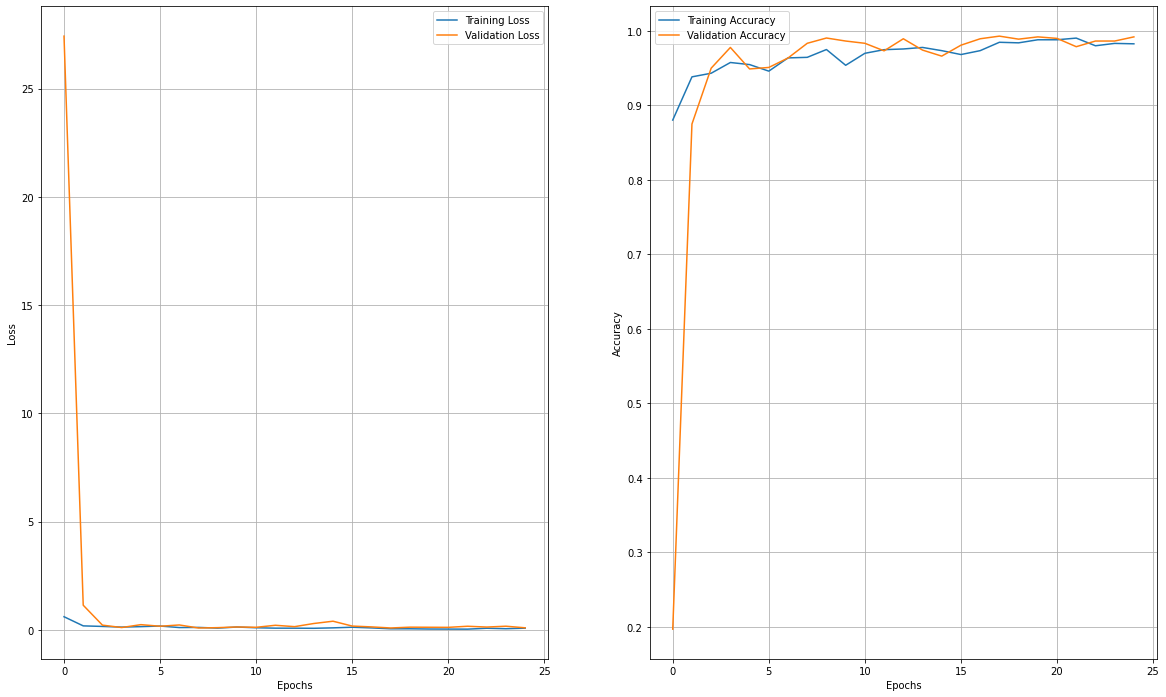

In [25]:
plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( history.history["loss"], label = "Training Loss")
plt.plot( history.history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot( history.history["accuracy"], label = "Training Accuracy")
plt.plot( history.history["val_accuracy"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

In [27]:
model.evaluate(X_val,Y_val)


62/62 [==============================] - 5s 85ms/step - loss: 0.0918 - accuracy: 0.9919


[0.09182848036289215, 0.9918987154960632]

In [28]:
model.save('./rottenvsfresh.h5')

In [29]:
from keras.models import Model, load_model


new_model=load_model('./rottenvsfresh.h5')


In [30]:
new_model.evaluate(X_val,Y_val)


62/62 [==============================] - 5s 86ms/step - loss: 0.0918 - accuracy: 0.1949


[0.09182848036289215, 0.19493670761585236]

In [46]:
#show_subpot(X_val[:4],title=True,Y=model.predict_classes(X_val[:4]))
model.predict_classes(X_val[:4])

array([1, 1, 1, 1])

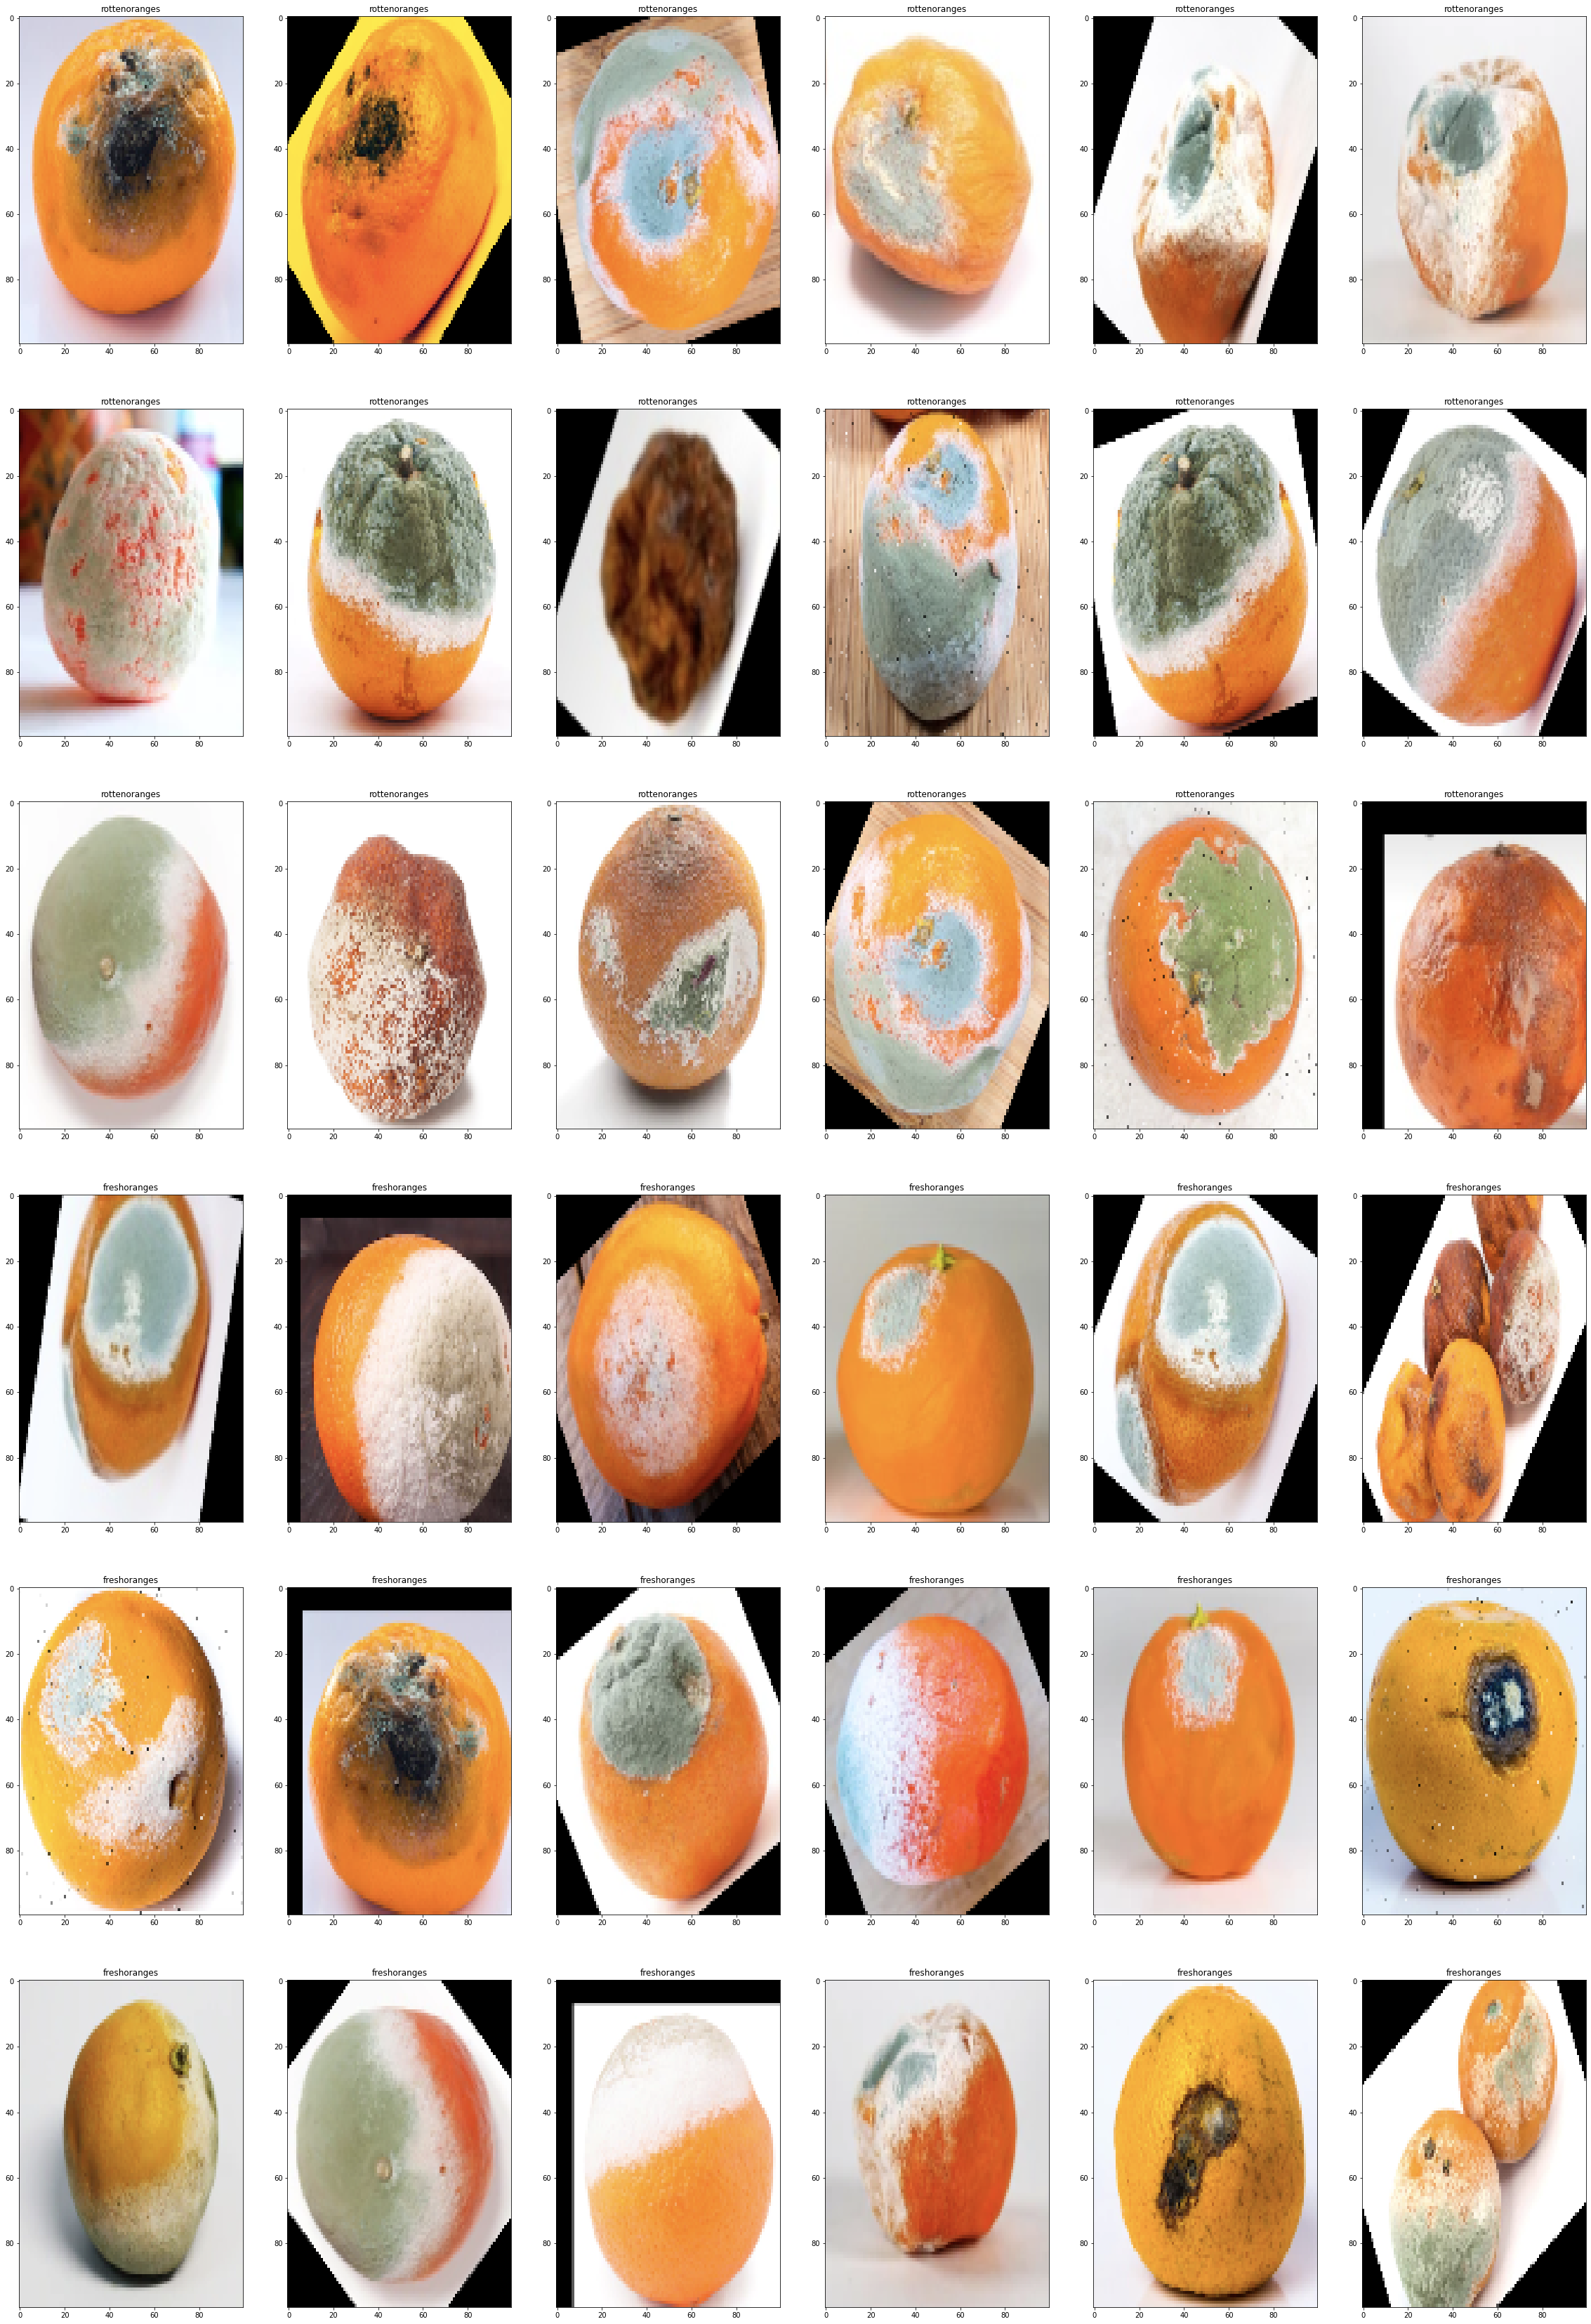

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [47]:
show_subpot(X_val[:36], title=False)
model.predict_classes(X_val[:36])